In [311]:
#import of neccessary libraries

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [313]:
# dataset with user belonging to the control or experimental group (A – control, B – target group)
test_group = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-darya-kot-yeg4789/groups.csv', sep=";")
test_group = test_group.rename(columns=({'id':'student_id'}))
test_group.head(5)

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [314]:
#dataset with users who visited the platform on the days of the experiment.
test_day_users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-darya-kot-yeg4789/active_studs.csv')
test_day_users.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [315]:
#dataset with users' payments during the experiment days 
payments = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-darya-kot-yeg4789/checks.csv', sep=';')
payments.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [316]:
#take users that were active during the experiment days

In [317]:
active_test_users = pd.merge(test_day_users,test_group,how='left', on='student_id')
active_test_users.head(5)

,student_id,grp
0,581585,A
1,5723133,NaN
2,3276743,B
3,4238589,A
4,4475369,B


In [318]:
active_test_users.isnull().sum()


student_id     0
grp           13
dtype: int64

In [319]:
#there are 13 null values in the group column - these are users who were active, 
#but not included in the control and test groups
#I remove such users from our dataset

In [320]:
active_test_users = active_test_users=active_test_users.dropna()
active_test_users

,student_id,grp
0,581585,A
2,3276743,B
3,4238589,A
4,4475369,B
5,5481015,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [321]:
#divide data by groups

In [322]:
stat_df = active_test_users.groupby('grp', as_index=False).agg({'student_id':'count'})
stat_df

,grp,student_id
0,A,1535
1,B,6793


In [323]:
#Changes in the payment flow may potentially affect the number of payments, revenue, average check, 
#and conversion rate.
#It can be assumed that the goal of modifying the payment mechanism is to increase revenue 
#and the number of payments.

#As the main evaluation metrics, I selected conversion rate and ARPPU between groups:

#Conversion rate helps assess whether the new flow impacted the number of payments,

#ARPPU shows whether total revenue increased.

#These metrics allow us to effectively measure the impact of the changes.

In [324]:
#Таким образом у нас есть следующие гипотезы:
#H0 - After new payments mechanism applying CR and ARPPU don't differ in groups
#Н1 - After new payments mechanism applying CR and ARPPU differ in groups

In [325]:
#Gather in dataset active users with the data of payments that were done by them

In [326]:
payments_active = pd.merge(payments,active_test_users,how='left', on='student_id')
payments_active

,student_id,rev,grp
0,1627,990.0,A
1,3185,690.0,NaN
2,25973,690.0,NaN
3,26280,690.0,NaN
4,100300,990.0,B
...,...,...,...
536,5645737,1900.0,B
537,5651566,1900.0,B
538,5662322,1900.0,B
539,5681918,1900.0,B


In [327]:
payments_active.isnull().sum()

student_id      0
rev             0
grp           150
dtype: int64

In [328]:
#There are null values in group column, which indicates that the user made a payment but did not visit the site 
#during the experiment period.
#This could suggest either an automatic subscription renewal or a data collection error.

#Such users are excluded from the analysis,
#as they did not actually participate in the experiment. → Therefore, when calculating the number of payments 
#per group, we remove notes with null values.

In [329]:
processed_active_payments = payments_active.dropna()
processed_active_payments

,student_id,rev,grp
0,1627,990.0000,A
4,100300,990.0000,B
8,108270,290.0000,B
26,264473,1900.0001,B
27,274352,690.0000,B
...,...,...,...
535,5609523,1900.0000,B
536,5645737,1900.0000,B
537,5651566,1900.0000,B
538,5662322,1900.0000,B


In [330]:
processed_active_payments.student_id.nunique()

391

In [331]:
# I will further use metric ARPPU in statistical test because each student_id is distinct in processed_active_payments
#(number if distinct ids = number of rows in dataset)

In [332]:
#calsulate number of payments by groups

In [333]:
count_payments = processed_active_payments.groupby('grp', as_index=False).agg({'student_id':'count'})
count_payments

,grp,student_id
0,A,78
1,B,313


In [334]:
#calculate revenue by groups

In [335]:
rev_sum = processed_active_payments.groupby('grp', as_index=False).agg({'rev':'sum'})
rev_sum

,grp,rev
0,A,72820.0000
1,B,393074.0035


In [336]:
#create general dataset with metrics by groups

In [337]:
upd_stat = pd.merge(stat_df,count_payments,how='left', on='grp')
final_group_stats = pd.merge(upd_stat,rev_sum,how='left', on='grp')
final_group_stats = final_group_stats.rename(columns=({'student_id_x':'size', 'student_id_y':'payments','rev':'revenue'}))

In [338]:
final_group_stats

,grp,size,payments,revenue
0,A,1535,78,72820.0000
1,B,6793,313,393074.0035


In [339]:
#To test the statistical significance of the difference in conversion rates between groups, 
#I use a Z-test for proportions.

#H₀: There is no difference in proportions between the groups.
#H₁: The proportions differ between the groups.

In [340]:
from statsmodels.stats.proportion import proportions_ztest

successes = [final_group_stats.iloc[0,2], final_group_stats.iloc[1,2]]
n_obs = [final_group_stats.iloc[0,1], final_group_stats.iloc[1,1]]

z_stat, p_val = proportions_ztest(successes, n_obs)
print(f'Z-stat: {z_stat:.4f}, p-value: {p_val:.4f}')


Z-stat: 0.7925, p-value: 0.4281


In [341]:
#Since the p-value > 0.05, there is no statistically significant difference in the share of payments
#between the control and test groups.
#Therefore, based on this test, there is no evidence that the new payment mechanism 
#leads to a change in conversion rate — at least in terms of the number of payments.

In [342]:
#Checking the distribution of data in each group for normality:

#H₀: The data is normally distributed
#H₁: The data is not normally distributed

In [343]:
rev_A = processed_active_payments[['rev','grp']].query('grp=="A"')['rev']
rev_A

0       990.0
31     1830.0
41     2910.0
44     2820.0
64     3660.0
        ...  
517     990.0
525    1160.0
529     290.0
531     489.0
532     590.0
Name: rev, Length: 78, dtype: float64

In [344]:
rev_B = processed_active_payments[['rev','grp']].query('grp=="B"')['rev']
rev_B

4       990.0000
8       290.0000
26     1900.0001
27      690.0000
29      199.0000
         ...    
535    1900.0000
536    1900.0000
537    1900.0000
538    1900.0000
539    1900.0000
Name: rev, Length: 313, dtype: float64

In [345]:
import scipy.stats as sps
print(sps.shapiro(rev_A))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)


In [346]:
print(sps.shapiro(rev_B))

ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)


In [347]:
#The data in both groups is not normally distributed (p-value<0.05)

In [348]:
#Visualizing distributions in groups

Text(0.5, 1.0, 'Distribution of data in A group')

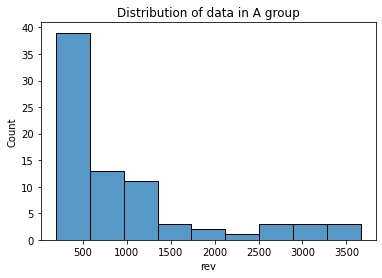

In [349]:
sns.histplot(data=rev_A)
plt.title('Distribution of data in A group')

Text(0.5, 1.0, 'Distribution of data in B group')

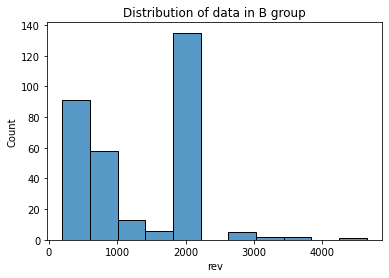

In [350]:
sns.histplot(data=rev_B)
plt.title('Distribution of data in B group')

In [351]:
# The data in both Group A and Group B is not normally distributed, as the p-value < 0.05.
#The distribution plots also indicate that the data does not follow a normal distribution.

In [352]:
#Since the sample sizes in the groups are significantly different, we will test distributions for homoscedasticity
#The data is not normally distributed, so I will use the Brown-Forsythe method
#H0 - Variances in the groups are equal
#H1 - Variances in the groups differ

In [353]:
from scipy.stats import levene

stat, p = levene(rev_A, rev_B, center='median')

print(f"Статистика: {stat}, p-value: {p}")

Статистика: 3.0558643506726035, p-value: 0.08123509393501775


In [354]:
#p-value > 0.05 means that variances in the groups are equal

In [355]:
#The data in both samples have equal variances and are not normally distributed, 
#which allows us to use the Student's t-test to compare the ARPPU between groups.

#Although the data is not normally distributed, 
#the large sample size helps reduce the impact of not normal distribution due to the Central Limit Theorem (CLT).

#H₀: There is no difference in the group means

#H₁: The group means are different

In [356]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(rev_A, rev_B, equal_var=True)
print(f"t-статистика: {t_stat}, p-value: {p_value}")

t-статистика: -3.1114389810411063, p-value: 0.001999178025210522


In [357]:
#p-value < 0.05, which means the group means differ statistically significantly.

In [358]:
#Visualizing the distributions to observe the specific differences.

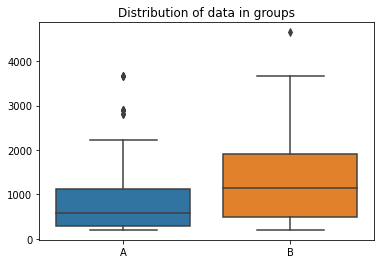

In [359]:
sns.boxplot(data=[rev_A, rev_B])
plt.xticks([0, 1], ['А', 'В'])
plt.title('Distribution of data in groups')
plt.show()


In [360]:
#from the plot it's seen that mediana in group B is higher 

In [361]:
#let's look at the practical effect (how metrics have changed)

In [362]:
final_group_stats['ARPPU']=final_group_stats['revenue']/final_group_stats['payments']
final_group_stats['CR']=final_group_stats['payments']/final_group_stats['size']
final_group_stats['ARPU']=final_group_stats['revenue']/final_group_stats['size']
final_group_stats

,grp,size,payments,revenue,ARPPU,CR,ARPU
0,A,1535,78,72820.0000,933.589744,0.050814,47.439739
1,B,6793,313,393074.0035,1255.827487,0.046077,57.864567


Text(0.5, 1.0, 'Revenue')

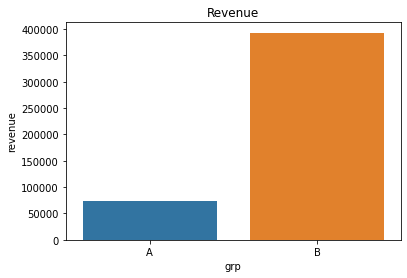

In [363]:
 #Visualize revenue by groups 
plt.figure()
sns.barplot(data=final_group_stats, x='grp', y='revenue')
plt.title('Revenue')
    

In [364]:
#How revenue has changed 

In [365]:
round((final_group_stats.iloc[1,3]-final_group_stats.iloc[0,3])/final_group_stats.iloc[0,3]*100,2)

439.79

Text(0.5, 1.0, 'Conversion rate')

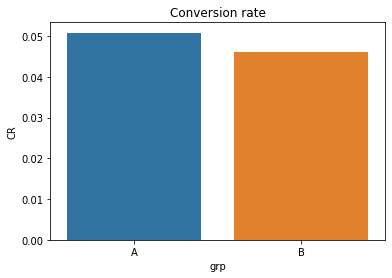

In [366]:
#Visualize CR by groups
plt.figure()
sns.barplot(data=final_group_stats, x='grp', y='CR')
plt.title('Conversion rate')

In [367]:
#How CR has changed 

In [368]:
round((final_group_stats.iloc[1,5]-final_group_stats.iloc[0,5])*100,2)

-0.47

Text(0.5, 1.0, 'ARPPU')

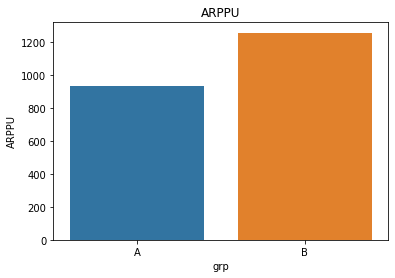

In [369]:
#Visualize ARPPU 
plt.figure()
sns.barplot(data=final_group_stats, x='grp', y='ARPPU')
plt.title('ARPPU')

In [370]:
#Calculate the increase in the ARPPU (in %) between the test and control groups

In [371]:
round((final_group_stats.iloc[1,4]-final_group_stats.iloc[0,4])/final_group_stats.iloc[0,4]*100,2)

34.52

Text(0.5, 1.0, 'ARPU')

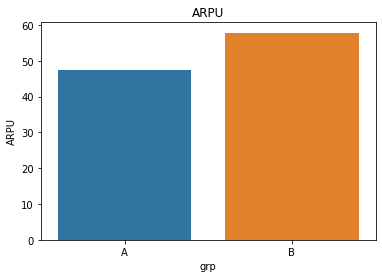

In [372]:
#Visualize ARPU 
plt.figure()
sns.barplot(data=final_group_stats, x='grp', y='ARPU')
plt.title('ARPU')

In [373]:
#How ARPU has changed

In [374]:
round((final_group_stats.iloc[1,6]-final_group_stats.iloc[0,6])/final_group_stats.iloc[0,6]*100,2)

21.97

In [375]:
#Based on the obtained data, I can conclude that the new payment mechanism affected revenue, 
#as the ARPPU differs significantly between groups (p-value < 0.05). 
#However, since the number of payments does not differ statistically between groups, 
#the changes did not impact the share of paying customers.

#Despite a similar share of paying customers, the new mechanism increases revenue and ARPPU. 
#Therefore, it is recommended to launch the new payment mechanism with the goal of increasing revenue.